# Tâche 8: les bandes électroniques

In [101]:
from pymatgen.ext.matproj import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.io.cif import CifWriter
from pymatgen import Spin
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure import plotter

import numpy as np
import matplotlib.pyplot as plt
import math

In [102]:
with MPRester("WOCEDvyZTdTuSHXq") as m:
    bandStructure = m.get_bandstructure_by_material_id("mp-15988")
    
print(" Le matériau à analyser est le Li2CuSb")

 Le matériau à analyser est le Li2CuSb


## 1) Graphe de la structure de bandes électroniques

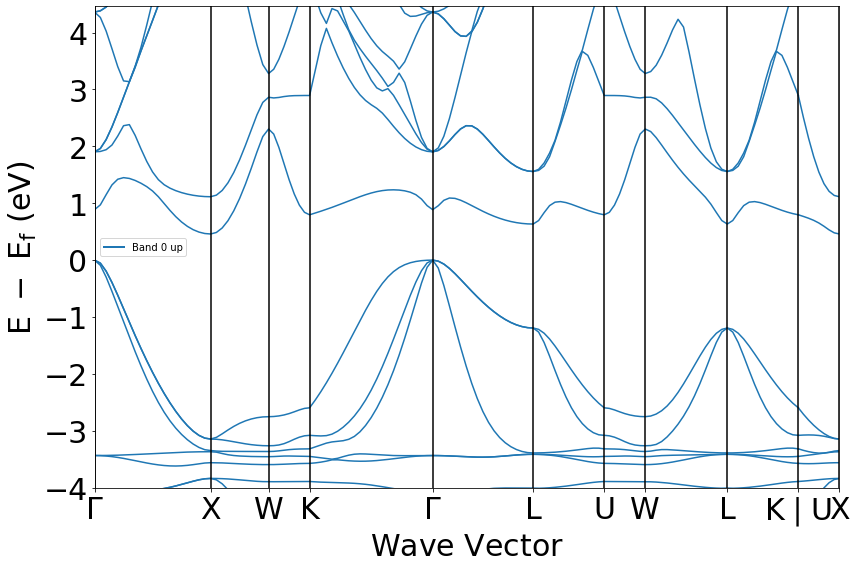

In [103]:
BSP = BSPlotter(bandStructure)
BSP.show()

## 2) La bande interdite

In [104]:
bandGap = bandStructure.get_band_gap()
print("La bande interdite est indirecte car bandGap['direct']=" , bandGap['direct'])
print('La largeur du gap est de:', bandGap['energy'], 'eV')
print("Le vecteur d'onde se déplace dans la direction:", bandGap['transition'])

La bande interdite est indirecte car bandGap['direct']= False
La largeur du gap est de: 0.45920000000000005 eV
Le vecteur d'onde se déplace dans la direction: \Gamma-X


### Analyse de la dernière bande de valence

Soient VBM et CBM respectivement pour balance band maximum et conduction band minimum

In [105]:
data = BSPlotter(bandStructure).bs_plot_data()
distances = data.get('distances')
ticks = data.get('ticks')
distance = ticks.get('distance')
E_f = data.get('zero_energy')

VBM = bandStructure.get_vbm()
index_VBM = VBM['band_index']
E_VBM = VBM['energy']
KPoint_VBM = VBM['kpoint'].cart_coords

print(index_VBM, "\n")
print("- La dernière bande de valence est la bande 13")
print("- On retrouve sur le graphe (ci-dessous), le maximum de la dernière bande de valence (VBM) en E_VBM - E_f =", E_VBM-E_f, "eV")
print("remarque: ici le maximum est le même pour les 3 dernières bandes de valence")
print("où E_VBM = E_f =", E_VBM, 'eV')
print("- Avec comme vecteur k: k =", KPoint_VBM)



defaultdict(<class 'list'>, {<Spin.up: 1>: [11, 12, 13]}) 

- La dernière bande de valence est la bande 13
- On retrouve sur le graphe (ci-dessous), le maximum de la dernière bande de valence (VBM) en E_VBM - E_f = 0.0 eV
remarque: ici le maximum est le même pour les 3 dernières bandes de valence
où E_VBM = E_f = 6.4969 eV
- Avec comme vecteur k: k = [0. 0. 0.]


### Analyse de la première bande de conduction 

In [106]:
CBM = bandStructure.get_cbm()
index_CBM = CBM['band_index']
E_CBM = CBM['energy']
KPoint_CBM = CBM['kpoint'].cart_coords

print(index_CBM, "\n")
print("- La première bande de conduction est la bande 14")
print("- On retrouve sur le graphe (ci-dessous), le minimum de la première bande de conduction (CBM) en E_CBM - E_f =", E_CBM-E_f, "eV")
print("où E_CBM = ", E_VBM, 'eV')
print("- Avec comme vecteur k: k =", KPoint_CBM)

defaultdict(<class 'list'>, {<Spin.up: 1>: [14]}) 

- La première bande de conduction est la bande 14
- On retrouve sur le graphe (ci-dessous), le minimum de la première bande de conduction (CBM) en E_CBM - E_f = 0.45920000000000005 eV
où E_CBM =  6.4969 eV
- Avec comme vecteur k: k = [ 1.66533454e-16  9.92025397e-01 -5.55111512e-17]


## Plot du graphe 

Text(0.5, 1.0, 'Structure des bandes électroniques du Li2CuSb')

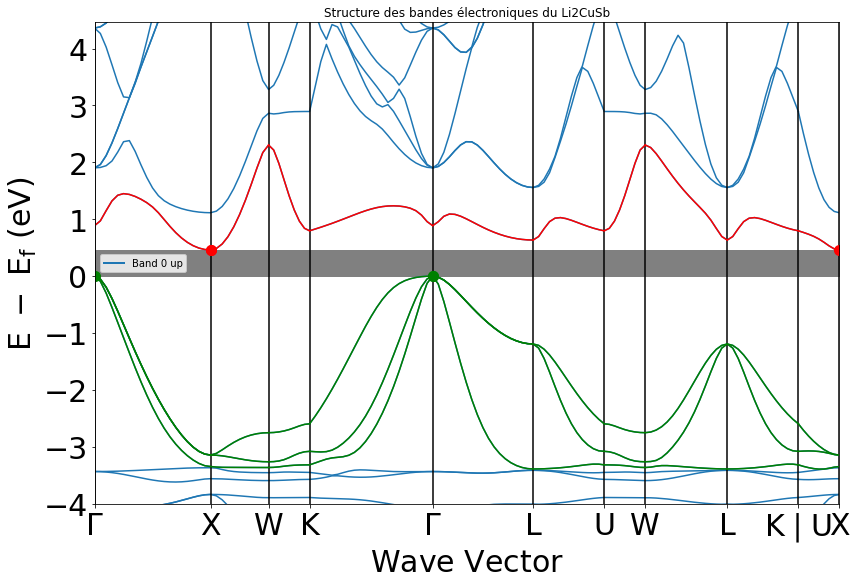

In [107]:
# Initialisation de quelques données
plot = plotter.BSPlotter(bandStructure)
energy = data.get('energy')
plot.get_plot()

# Afin de faire apparaitre en vert les dernières bande de valence
#    et en rouge la première bande de conduction
for i in range(10):
    plt.plot(distances[i],energy.get('1')[i][11],'green')
    plt.plot(distances[i],energy.get('1')[i][12],'green')
    plt.plot(distances[i],energy.get('1')[i][13],'green')
    plt.plot(distances[i],energy.get('1')[i][14],'red')
    
# Afin de faire apparaitre les CBM sur le graphe
cbms = data.get('cbm')
for i in range(len(cbms)):
    (x,y) = cbms[i]
    plt.plot(x, y, 'or', markersize = 10)

# Afin de faire apparaitre les VBM sur le graphe    
vbms = data.get('vbm')
for i in range(len(vbms)):
    (x,y) = vbms[i]
    plt.plot(x, y, 'og', markersize = 10)

# Afin de tracer la bande interdite 
plt.fill_between(np.linspace(distance[0], distance[-1], 500), 0, bandGap.get('energy'), color = "grey")

# Pour le titre 
plt.title('Structure des bandes électroniques du Li2CuSb')

### Légende du graphe:
- Les points rouges représentent les minimums de la bande première de conduction (en rouge), la bande 14
- Les points verts représentent les maximums des trois dernières bandes de valence (en vert), les bandes 11, 12, 13
- La bande interdite est coloriée en gris
- Les autres bandes bleues

# 3) Représentation des directions de dispersions maximales


- Soit E(k) une direction de dispersion calculée en fonction du taux de variation de l'énergie lorsqu'on varie le vecteur k

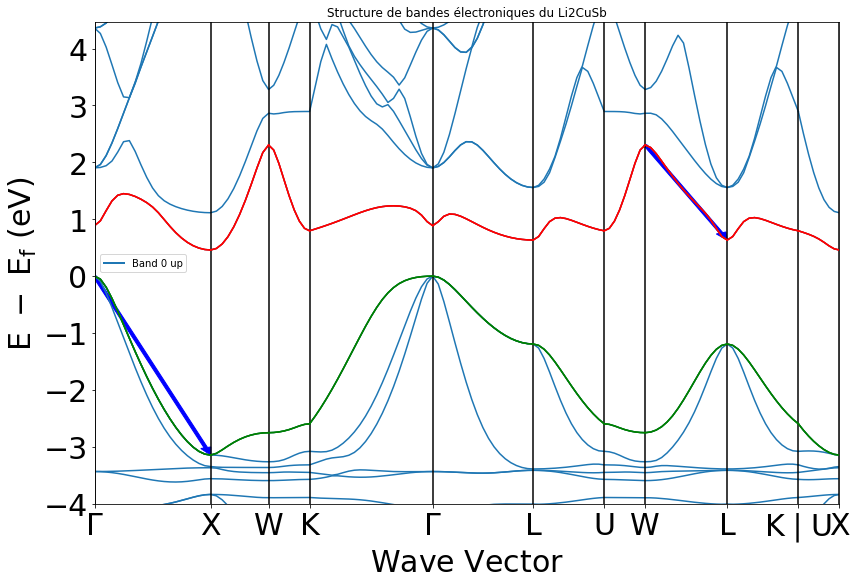

In [108]:

def grandeDispersion(y):
    """
    Output :
    - index :  l'index pour lequelle la direction possède la dispersion est maximale 
    - first : energie initiale de la dispersion maximale
    - last : energie finale de la dispersion maximale
    - pente : la pente entre les points first et last
    """
    
    energie = energy.get('1')
    pente = 0
    index = 0
    first = 0
    last = 0
    
    for i in range(10):
        x = energie[i][y]
        dist = distances[index][-1] - distances[index][0]
        val = (abs(x[0] - x[-1])) / dist
        if (val > pente): 
            index = i 
            first = x[0]
            last = x[-1]
            pente = val
    
    return [index, first, last, pente]


def fleche(y): 
    """
    Output :  
    - Tracer les flèches bleues qui montrent la plus grande dispersion 
    - Tracer la dernière bande de valence en vert
    - Tracer la première bande de conduction en rouge
    """
    
    a = grandeDispersion(y)
    X0 = distances[a[0]][0]
    X1 = distances[a[0]][-1]
    
    plt.arrow(X0, a[1], X1 - X0, a[2] - a[1], color = 'b',width = 0.03,length_includes_head = True )
    
    for i in range(10):
        plt.plot(distances[i],energy.get('1')[i][13],'green')
        plt.plot(distances[i],energy.get('1')[i][14],'red')
    
plot.get_plot()
plt.title('Structure de bandes électroniques du Li2CuSb')
fleche(13)
fleche(14)

Ce graphique représente les plus grandes dispersions par des flèches bleues pour la première bande de conduction (en rouge) et la dernière bande de valence (en vert). 

Elles ont lieu respectivement dans la direction W-L et dans la direction Γ-X

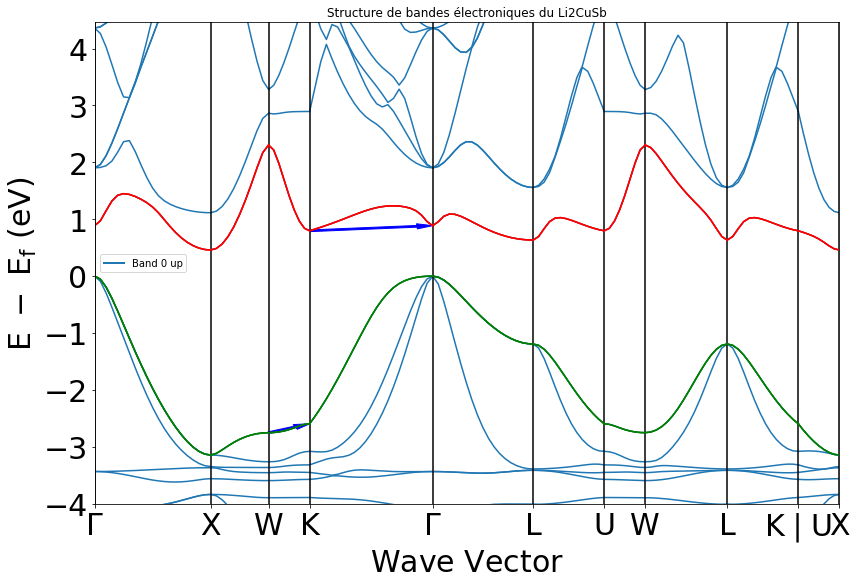

In [109]:

def petiteDispersion(y):
    """
    Output :
    - index :  l'index pour lequelle la direction possède la dispersion est minimale 
    - first : energie initiale de la dispersion maximale
    - last : energie finale de la dispersion maximale
    - pente : la pente entre les points first et last
    """
    
    energie = energy.get('1')
    pente = 100
    index = 0
    first = 0
    last = 0
    
    for i in range(10):
        x = energie[i][y]
        dist = distances[index][-1] - distances[index][0]
        val = (abs(x[0] - x[-1])) / dist
        if (val < pente): 
            index = i 
            first = x[0]
            last = x[-1]
            pente = val
    
    return [index, first, last, pente]


def fleche(y): 
    """
    Output :  
    - Tracer les flèches bleues qui montrent la plus petite dispersion 
    - Tracer la dernière bande de valence en vert
    - Tracer la première bande de conduction en rouge
    """
    
    a = petiteDispersion(y)
    X0 = distances[a[0]][0]
    X1 = distances[a[0]][-1]
    
    plt.arrow(X0, a[1], X1 - X0, a[2] - a[1], color = 'b',width = 0.03,length_includes_head = True )
    
    for i in range(10):
        plt.plot(distances[i],energy.get('1')[i][13],'green')
        plt.plot(distances[i],energy.get('1')[i][14],'red')
    
plot.get_plot()
plt.title('Structure de bandes électroniques du Li2CuSb')
fleche(13)
fleche(14)

Ce graphique représente les plus petites dispersions par des flèches bleues pour la première bande de conduction (en rouge) et la dernière bande de valence (en vert).

Elles ont lieu respectivement dans la direction K-Γ et dans la direction W-K

# 3) Masses effectives

En supposant que la dispersion est parabolique, en isolant la masse effective et pour un k donné à 3 dimensions, nous pouvont faire ce calcul:

In [110]:
h_bar = 6.5821e-16
m_e = 9.11e-31
m_VBM = (h_bar**2 * (KPoint_VBM[0]**2+KPoint_VBM[1]**2+KPoint_VBM[2]**2))/(2*abs(E_VBM))
m_CBM = (h_bar**2 * (KPoint_CBM[0]**2+KPoint_CBM[1]**2+KPoint_CBM[2]**2))/(2*E_CBM)
print('La masse effective au sommet de la dernière bande de valence =', m_VBM, 'kg', '=',  m_VBM/m_e, 'm_e')
print('La masse effective à la base de la première bande de conduction =', m_CBM, 'kg')

La masse effective au sommet de la dernière bande de valence = 0.0 kg = 0.0 m_e
La masse effective à la base de la première bande de conduction = 3.0646347492418965e-32 kg
